# Convolution Neural Network

Generator for this dataset is taken from the project:
https://github.com/matthewearl/deep-anpr

In [18]:
%matplotlib inline
import random
import time
import numpy as np
import pandas as pd
from sklearn import cross_validation
from skimage import io
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import tensorflow as tf
from pylab import rcParams

DATA_PATH = '../data/artificial-10k/'
MODEL_PATH = '../model/artificial2'

## Import data

Data is stored in csv file. Images are saved as PNG files.

Data will be loaded into the following variables:
  * X - Images, (num_of_images, image_height, image_width) Tensor
  * Y - Labels, (num_of_images, 4) left, top, right, bottom 

In [5]:
def load_image(fname):
    return io.imread(DATA_PATH + fname) / 256.

df = pd.read_csv(DATA_PATH + 'train.csv')
img = load_image(df.iloc[0].image)
print('Image dimension: ' + str(img.shape))
df.head()

Image dimension: (64, 128)


,image,plate,left,top,right,bottom
0,00000000_XR30PGY.png,XR30PGY,44,28,85,38
1,00000001_PK69KBA.png,PK69KBA,70,27,116,37
2,00000002_VH93KAI.png,VH93KAI,56,26,100,37
3,00000003_AD11AAS.png,AD11AAS,43,28,85,40
4,00000004_WO98LGQ.png,WO98LGQ,83,19,123,27


Basic image information

In [6]:
xs = [load_image(fname) for fname in df['image']]
X = np.array(xs)
Y = df[['left', 'top', 'right', 'bottom']].as_matrix()
print('Images shape: ' + str(X.shape))
print('Labels shape: ' + str(Y.shape))

Images shape: (10000, 64, 128)
Labels shape: (10000, 4)


### Show sample images

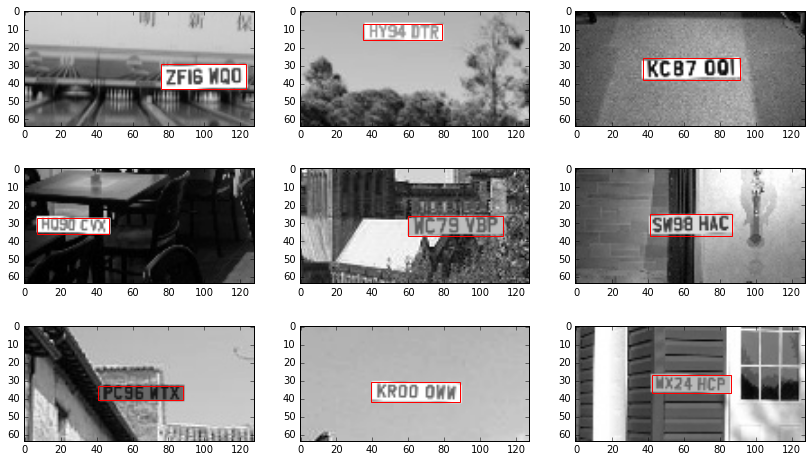

In [27]:
def show_image(image, labels):
    rect = Rectangle((labels[0], labels[1]), labels[2]-labels[0], labels[3]-labels[1], edgecolor='r', fill=False)
    plt.imshow(image)
    gca = plt.gca()
    gca.add_patch(rect)
    
def plot_images(images, labels):
    rcParams['figure.figsize'] = 14, 8
    plt.gray()
    fig = plt.figure()
    for i in range(min(9, images.shape[0])):
        fig.add_subplot(3, 3, i+1)
        show_image(images[i], labels[i])
    plt.show()    
    
xs = [random.randint(0, X.shape[0]-1) for _ in range(9)]                   
plot_images(X[xs], Y[xs])    

## Build Tensorflow neural net

### Define loss function

We will optimize mean square error over all predictions.

$$MSE = \frac{1}{n} \sum_{i=1}^{n}{(\hat{y_i} - y_i)^2}$$

In [8]:
def mse(expected, predicted):
    se = tf.square(expected - predicted)
    return tf.reduce_mean(se)

### Helpers

In [43]:
class Dataset:

    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        self._epochs_completed = 0
        self._index_in_epoch = 0
        self._num_examples = X.shape[0]

    def next_batch(self, batch_size=20):
        start = self._index_in_epoch
        self._index_in_epoch += batch_size
        if self._index_in_epoch > self._num_examples:
            self._epochs_completed += 1
            # Shuffle the data
            perm = np.arange(self._num_examples)
            np.random.shuffle(perm)
            self.X = self.X[perm]
            self.Y = self.Y[perm]
            # Start next epoch
            start = 0
            self._index_in_epoch = batch_size
            assert batch_size <= self._num_examples
        end = self._index_in_epoch
        return self.X[start:end], self.Y[start:end]

    def epoch_completed(self):
        return self._epochs_completed
    
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)


def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)


def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')


def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')    

### Build model

In [46]:
HIDDEN_1_SIZE = 100
PIXEL_COUNT = X.shape[1] * X.shape[2]
LABEL_COUNT = Y.shape[1]
# Create placeholders for image data and expected point positions
x_placeholder = tf.placeholder(tf.float32, shape=[None, PIXEL_COUNT])
y_placeholder = tf.placeholder(tf.float32, shape=[None, LABEL_COUNT])

# Build neural network
def build_model(xs):
    x_image = tf.reshape(xs, [-1, 64, 128, 1])
    # Convolution Layer 1
    W_conv1 = weight_variable([3, 3, 1, 32])
    b_conv1 = bias_variable([32])
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)
    # Convolution Layer 2
    W_conv2 = weight_variable([2, 2, 32, 64])
    b_conv2 = bias_variable([64])
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2)
    # Convolution Layer 3
    W_conv3 = weight_variable([2, 2, 64, 128])
    b_conv3 = bias_variable([128])
    h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)
    h_pool3 = max_pool_2x2(h_conv3)
    # Dense layer 1
    h_pool3_flat = tf.reshape(h_pool3, [-1, 8*16*128])
    W_fc1 = weight_variable([8*16*128, 500])
    b_fc1 = bias_variable([500])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool3_flat, W_fc1) + b_fc1)    
    # Dense layer 2
    W_fc2 = weight_variable([500, 500])
    b_fc2 = bias_variable([500])
    h_fc2 = tf.nn.relu(tf.matmul(h_fc1, W_fc2) + b_fc2)    
    # Output layer
    W_out = weight_variable([500, LABEL_COUNT])
    b_out = bias_variable([LABEL_COUNT])
    return tf.matmul(h_fc2, W_out) + b_out


# Define loss function
model = build_model(x_placeholder)
loss = mse(y_placeholder, model)

### Train

In [49]:
X2 = np.reshape(X, (X.shape[0], X.shape[1]*X.shape[2]))
Y2 = Y / (64, 32, 64, 32) - 1
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X2, Y2, train_size=0.8)
dataset = Dataset(X_train, Y_train)
saver = tf.train.Saver()
EPOCH = 1e1
with tf.Session() as session:
    start_time = time.time()
    best_score = 1
    session.run(tf.initialize_all_variables())
    train_step = tf.train.GradientDescentOptimizer(5e-5).minimize(loss)
    last_epoch = -1
    while dataset.epoch_completed() < EPOCH:
        (batch_x, batch_y) = dataset.next_batch(20)
        train_step.run(feed_dict={x_placeholder: batch_x, y_placeholder: batch_y})
        if dataset.epoch_completed() > last_epoch:
            last_epoch = dataset.epoch_completed()
            score_test = loss.eval(feed_dict={x_placeholder: X_test, y_placeholder: Y_test})
            if score_test < best_score:
                best_score = score_test
                saver.save(session, MODEL_PATH)
            if dataset.epoch_completed() % 1 == 0:
                print('Epoch: %d, Score: %f' % (dataset.epoch_completed(), score_test))
    print('Finished in %d seconds.' % (time.time()-start_time))  


Epoch: 0, Score: 8.839350
Epoch: 1, Score: 0.271797
Epoch: 2, Score: 0.225246
Epoch: 3, Score: 0.198587
Epoch: 4, Score: 0.180656
Epoch: 5, Score: 0.168368
Epoch: 6, Score: 0.157338
Epoch: 7, Score: 0.145914
Epoch: 8, Score: 0.138134
Epoch: 9, Score: 0.131892
Epoch: 10, Score: 0.127271
Finished in 1018 seconds.


### Show test set predictions

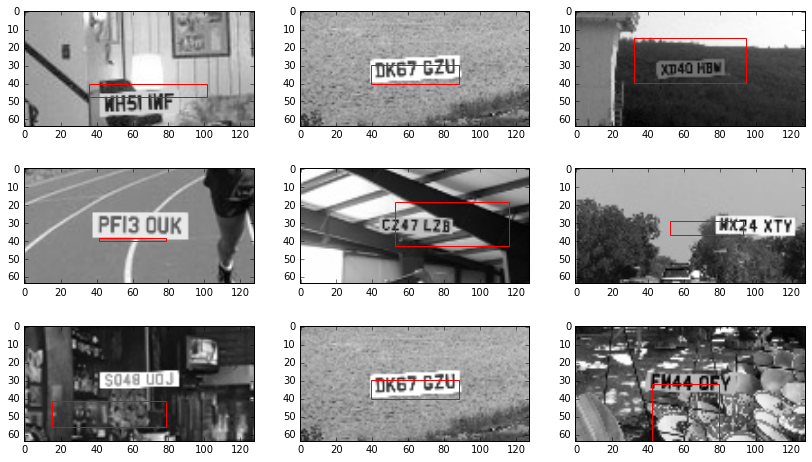

In [51]:
with tf.Session() as session:
    saver.restore(session, MODEL_PATH)
    ids = [random.randint(0, X_test.shape[0]-1) for _ in range(9)]
    Y2_test = model.eval(feed_dict={x_placeholder: X_test[ids]})
    xs = np.reshape(X_test, (X_test.shape[0], X.shape[1], X.shape[2]))
    plot_images(xs[ids], (Y2_test+1) * (64, 32, 64, 32))

### Show train set predictions

IndexError: index 9 is out of bounds for axis 0 with size 9

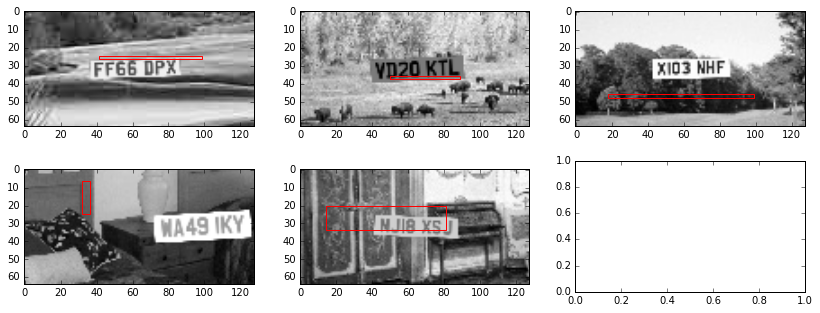

In [52]:
with tf.Session() as session:
    saver.restore(session, MODEL_PATH)
    ids = [random.randint(0, X_train.shape[0]-1) for _ in range(9)]
    Y2_train = model.eval(feed_dict={x_placeholder: X_train[ids]})
    xs = np.reshape(X_train, (X_train.shape[0], X.shape[1], X.shape[2]))
    plot_random_images(xs[ids], (Y2_train+1) * (64, 32, 64, 32))